## 1. Configuración Inicial

In [1]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import sys
from pathlib import Path

# Configurar estilos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Agregar src al path
sys.path.append('..')

# Importar módulos del proyecto
from src.data.loader import EEGLoader
from src.data.parser import EventParser
from src.utils.config import load_config

print("Librerías importadas correctamente ✓")

Librerías importadas correctamente ✓


In [2]:
# Cargar configuración
config = load_config('../config.yaml')

# Parámetros principales
DATA_DIR = config['data']['raw_path']
IMAGERY_RUNS = config['subjects']['runs_of_interest']
MOTOR_CHANNELS = config['eeg']['motor_channels']

print(f"Directorio de datos: {DATA_DIR}")
print(f"Runs de interés: {IMAGERY_RUNS}")
print(f"Canales motor cortex: {MOTOR_CHANNELS}")

Directorio de datos: data/raw
Runs de interés: ['R04', 'R06', 'R08', 'R10', 'R12', 'R14']
Canales motor cortex: ['C3', 'C4', 'Cz', 'FC3', 'FC4', 'CP3', 'CP4', 'C1', 'C2', 'C5', 'C6']


## 2. Exploración del Dataset

In [4]:
# Inicializar loader y parser
# Nota: Desde notebooks/
loader = EEGLoader('../' + DATA_DIR)
parser = EventParser('../' + DATA_DIR)

# Listar sujetos disponibles
subjects = loader.list_available_subjects()
print(f"Número de sujetos disponibles: {len(subjects)}")
print(f"Primeros 10 sujetos: {subjects[:10]}")

Número de sujetos disponibles: 109
Primeros 10 sujetos: ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']


In [5]:
# Explorar runs del primer sujeto
subject = "S001"
runs = loader.list_available_runs(subject)
print(f"\nRuns disponibles para {subject}: {runs}")

# Filtrar solo runs de imaginación motora
imagery_runs = [r for r in runs if r.upper() in IMAGERY_RUNS]
print(f"Runs de imaginación motora: {imagery_runs}")


Runs disponibles para S001: ['R01', 'R02']
Runs de imaginación motora: []


In [7]:
# Obtener información de una grabación
run = "R04"  # Primera run de imaginación motora (manos)
info = loader.get_info(subject, run)

print(f"\nInformación de {subject}{run}:")
print(f"  - Número de canales: {info['n_channels']}")
print(f"  - Frecuencia de muestreo: {info['sampling_rate']} Hz")
print(f"  - Duración: {info['duration']:.2f} segundos")
print(f"  - Número de muestras: {info['n_samples']}")
print(f"\nPrimeros 10 canales: {info['channel_names'][:10]}")


Información de S001R04:
  - Número de canales: 64
  - Frecuencia de muestreo: 160.0 Hz
  - Duración: 124.99 segundos
  - Número de muestras: 20000

Primeros 10 canales: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..']


## 3. Carga y Visualización de Señales EEG

In [8]:
# Cargar datos crudos
raw = loader.load_raw(subject, run)
print(raw)
print(f"\nCanales EEG disponibles: {len(raw.ch_names)}")

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

Canales EEG disponibles: 64


Using matplotlib as 2D backend.


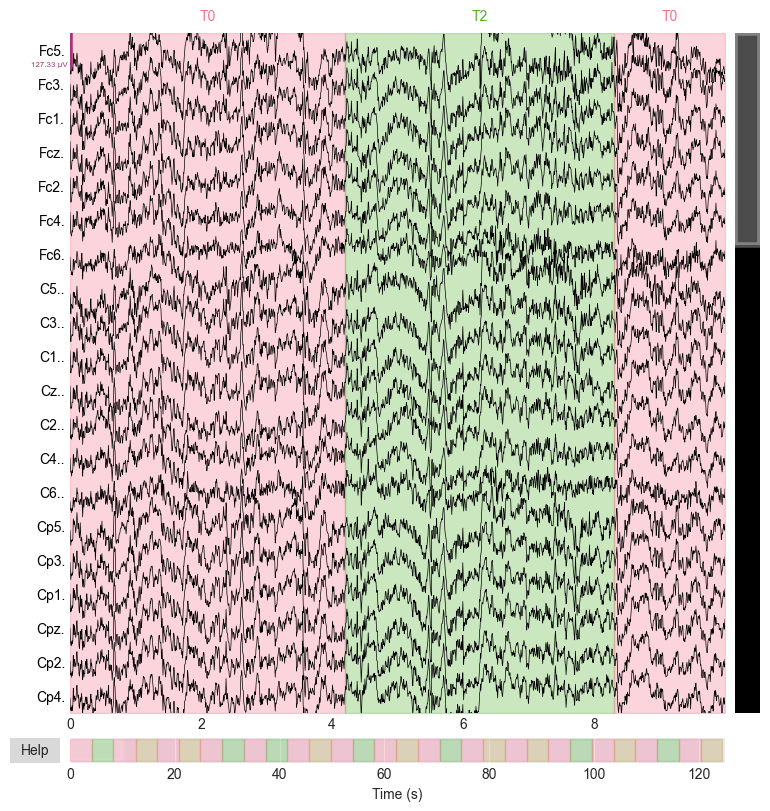

<Figure size 640x480 with 0 Axes>

In [9]:
# Visualizar señales crudas (primeros 10 segundos)
fig = raw.plot(duration=10, n_channels=20, scalings='auto', 
               title=f'{subject} {run} - Señales EEG Crudas',
               show=True, block=False)
plt.tight_layout()

In [10]:
# Visualizar solo canales del motor cortex
try:
    raw_motor = raw.copy().pick_channels(MOTOR_CHANNELS)
    fig = raw_motor.plot(duration=10, scalings='auto',
                         title=f'{subject} {run} - Canales Motor Cortex',
                         show=True, block=False)
except:
    print("Algunos canales del motor cortex no están disponibles")
    # Intentar con canales disponibles
    available_motor = [ch for ch in MOTOR_CHANNELS if ch in raw.ch_names]
    print(f"Canales disponibles: {available_motor}")
    if available_motor:
        raw_motor = raw.copy().pick_channels(available_motor)
        fig = raw_motor.plot(duration=10, scalings='auto',
                           title=f'{subject} {run} - Canales Motor Cortex',
                           show=True, block=False)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Algunos canales del motor cortex no están disponibles
Canales disponibles: []
Algunos canales del motor cortex no están disponibles
Canales disponibles: []


## 4. Análisis de Eventos

In [11]:
# Extraer eventos de las anotaciones
events, event_id = parser.parse_events_from_raw(raw)

print(f"Número total de eventos: {len(events)}")
print(f"\nIDs de eventos encontrados:")
for desc, id_val in event_id.items():
    count = np.sum(events[:, 2] == id_val)
    print(f"  {desc} (ID={id_val}): {count} eventos")

Número total de eventos: 30

IDs de eventos encontrados:
  T0 (ID=1): 15 eventos
  T1 (ID=2): 8 eventos
  T2 (ID=3): 7 eventos


In [12]:
# Mapear eventos a clases de imaginación motora
events_mapped, class_labels = parser.map_events_to_classes(events, event_id, run)

# Obtener resumen
summary = parser.get_event_summary(events_mapped, class_labels)

print("\nResumen de clases de imaginación motora:")
print(f"Total de eventos: {summary['total_events']}")
print(f"Clases únicas: {summary['unique_classes']}")
print(f"\nConteo por clase:")
for class_name, count in summary['class_counts'].items():
    print(f"  {class_name}: {count}")


Resumen de clases de imaginación motora:
Total de eventos: 30
Clases únicas: ['rest', 'right_hand', 'left_hand']

Conteo por clase:
  rest: 15
  right_hand: 7
  left_hand: 8


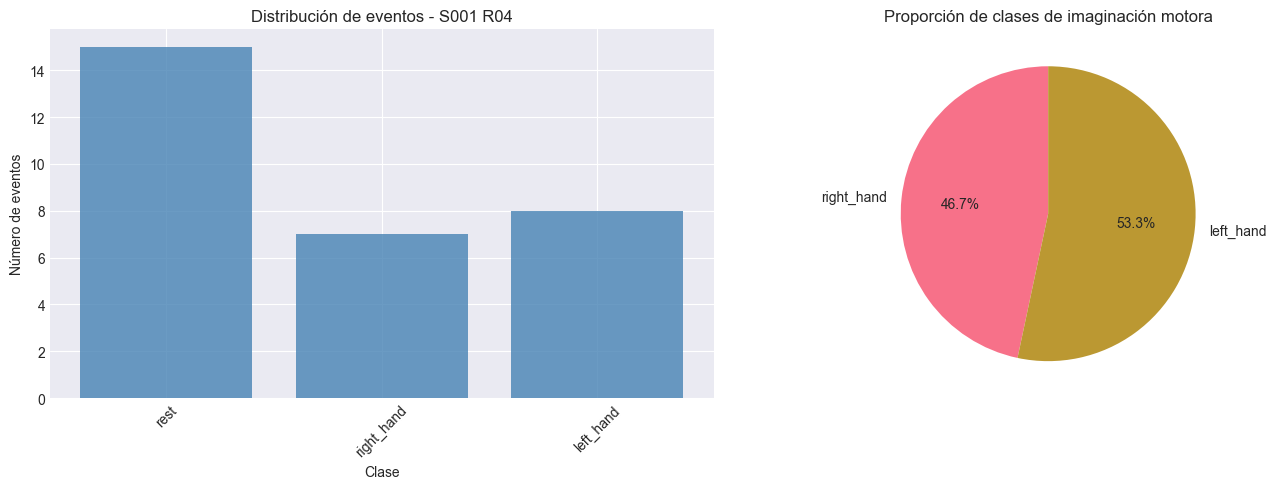

In [13]:
# Visualizar distribución de eventos
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
classes = list(summary['class_counts'].keys())
counts = list(summary['class_counts'].values())
ax[0].bar(classes, counts, color='steelblue', alpha=0.8)
ax[0].set_xlabel('Clase')
ax[0].set_ylabel('Número de eventos')
ax[0].set_title(f'Distribución de eventos - {subject} {run}')
ax[0].tick_params(axis='x', rotation=45)

# Gráfico circular (excluyendo rest)
non_rest_classes = {k: v for k, v in summary['class_counts'].items() 
                   if k not in ['rest', 'unknown']}
if non_rest_classes:
    ax[1].pie(non_rest_classes.values(), labels=non_rest_classes.keys(), 
             autopct='%1.1f%%', startangle=90)
    ax[1].set_title('Proporción de clases de imaginación motora')

plt.tight_layout()
plt.show()

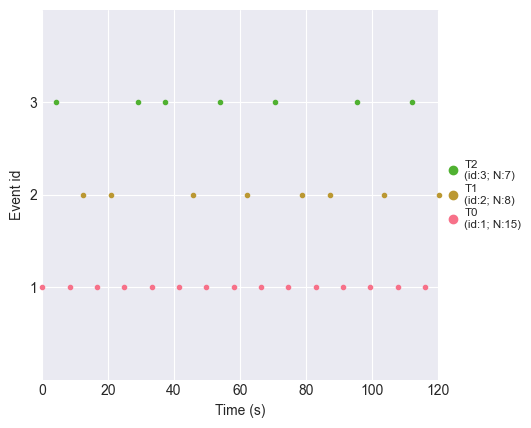

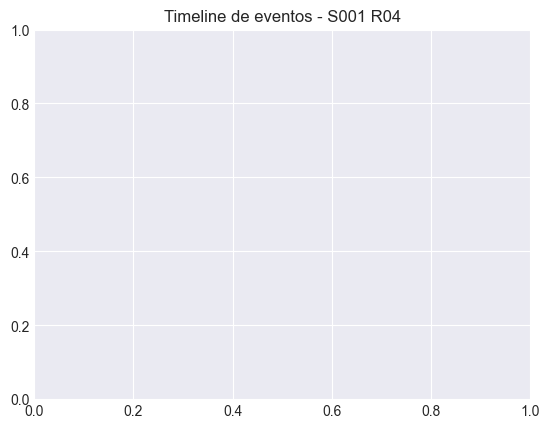

In [14]:
# Visualizar eventos en el timeline
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], 
                          first_samp=raw.first_samp,
                          event_id=event_id)
plt.title(f'Timeline de eventos - {subject} {run}')
plt.show()

## 5. Análisis de Múltiples Runs

In [15]:
# Analizar todas las runs de imaginación motora
imagery_runs_available = [r for r in runs if r.upper() in IMAGERY_RUNS]

run_summaries = {}
for run in imagery_runs_available[:3]:  # Analizar primeras 3 runs
    try:
        raw_temp = loader.load_raw(subject, run)
        events_temp, event_id_temp = parser.parse_events_from_raw(raw_temp)
        _, class_labels_temp = parser.map_events_to_classes(events_temp, event_id_temp, run)
        summary_temp = parser.get_event_summary(events_temp, class_labels_temp)
        run_summaries[run] = summary_temp
        print(f"✓ {run}: {summary_temp['total_events']} eventos")
    except Exception as e:
        print(f"✗ {run}: Error - {e}")

In [16]:
# Comparar distribución de clases entre runs
fig, axes = plt.subplots(1, len(run_summaries), figsize=(5*len(run_summaries), 4))

if len(run_summaries) == 1:
    axes = [axes]

for idx, (run, summary) in enumerate(run_summaries.items()):
    classes = [k for k in summary['class_counts'].keys() if k not in ['rest', 'unknown']]
    counts = [summary['class_counts'][k] for k in classes]
    
    axes[idx].bar(classes, counts, color='coral', alpha=0.8)
    axes[idx].set_title(f'{run}')
    axes[idx].set_ylabel('Número de eventos')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle(f'Comparación de eventos - {subject}', y=1.02)
plt.tight_layout()
plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x400 with 0 Axes>

## 6. Power Spectral Density (PSD) - Análisis Preliminar

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\1047663196.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw_for_psd.plot_psd(fmin=1, fmax=50, picks=channels_to_plot,
c:\Users\Lenovo\OneDrive\Desktop\PUCP\ISB\Proyecto-ISB\venv\lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


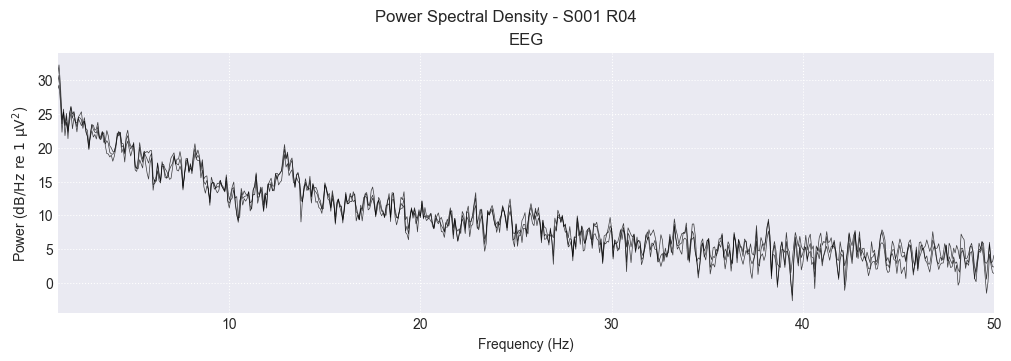

In [17]:
# Calcular PSD de señales crudas
raw_for_psd = loader.load_raw(subject, "R04")

# Seleccionar algunos canales del motor cortex
channels_to_plot = ['C3', 'Cz', 'C4'] if all(ch in raw_for_psd.ch_names for ch in ['C3', 'Cz', 'C4']) else raw_for_psd.ch_names[:3]

fig = raw_for_psd.plot_psd(fmin=1, fmax=50, picks=channels_to_plot,
                           average=False, show=True)
plt.suptitle(f'Power Spectral Density - {subject} R04')
plt.show()

## 7. Resumen de Hallazgos

### Observaciones:
1. **Dataset**: Contiene múltiples sujetos con 64 canales EEG @ 160 Hz
2. **Eventos**: Cada run contiene eventos T0 (rest), T1 y T2 que se mapean a clases de imaginación motora
3. **Clases**:
   - Runs R04, R08, R12: left_hand vs right_hand
   - Runs R06, R10, R14: both_hands vs both_feet
4. **Canales relevantes**: C3, C4, Cz (motor cortex) son los más importantes
5. **Calidad de señal**: Presencia de artefactos que requerirán preprocesamiento

### Próximos pasos (Fase 2):
- Implementar filtrado pasa-banda (8-30 Hz)
- Remover artefactos (EOG, EMG)
- Segmentar señales en epochs
- Normalizar datos

---
**Notebook completado** ✓